Setup Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"svenchnyu","key":"e9899f4c220c20289a004d1b8b2f5896"}'}

Create .kaggle directory move the uploaded file to it

In [ ]:
import shutil
import os

# Create .kaggle directory if it doesn't exist
os.makedirs('/root/.kaggle', exist_ok=True)

# Move kaggle.json to the correct location
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

Configure the permission

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

Verify kaggle configuration

In [ ]:
!kaggle datasets list

ref                                                               title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
abdulmalik1518/mobiles-dataset-2025                               Mobiles Dataset (2025)                             20KB  2025-02-18 06:50:24           9817        178  1.0              
atharvasoundankar/chocolate-sales                                 Chocolate Sales Data 📊🍫                            63KB  2025-03-07 05:44:03           2822         36  1.0              
ignacioazua/life-expectancy                                       Life Expectancy                                     3KB  2025-03-04 06:16:35           1236         28  1.0              
mahmoudelhemaly/students-grading-dataset                    

Download the dataset

In [ ]:
import kaggle
!kaggle competitions download -c deep-learning-spring-2025-project-1

 97% 183M/189M [00:01<00:00, 167MB/s]
100% 189M/189M [00:01<00:00, 158MB/s]


Verify the download

In [ ]:
print(os.listdir('/content'))

['.config', 'deep-learning-spring-2025-project-1.zip', 'sample_data']


Unzip the file

In [ ]:
!unzip -q deep-learning-spring-2025-project-1.zip -d /content/

Check the unzipped files

In [ ]:
print(os.listdir('/content'))

['.config', 'cifar_test_nolabel.pkl', 'cifar-10-python', 'deep-learning-spring-2025-project-1.zip', 'sample_data']


If everything went well, we are okay to remove the .zip file

In [ ]:
!rm deep-learning-spring-2025-project-1.zip

Now we are ready to train our mode, first, import packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import pickle
import pandas as pd
from PIL import Image

Split the data into train, test and validation set

In [2]:
Xtr_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=15),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
Xts_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
Xtr = datasets.CIFAR10(root='cifar-10-python', train=True, download=False, transform=Xtr_transform)
Xts = datasets.CIFAR10(root='cifar-10-python', download=False, transform=Xts_transform)

Xtr_loader = DataLoader(Xtr, batch_size=256, shuffle=True, num_workers=2)
Xts_loader = DataLoader(Xts, batch_size=256, shuffle=False, num_workers=2)

Create data loaders for each set

In [3]:
full_size = len(Xtr)
train_size = int(0.9 * full_size)
val_size = full_size - train_size
print(train_size)
print(val_size)

45000
5000


In [4]:
Xtr_, Xval_ = random_split(Xtr, [train_size, val_size])

# Print sizes
print(f"Training Set: {len(Xtr_)} images")
print(f"Validation Set: {len(Xval_)} images")
print(f"Test Set: {len(Xts)} images")

Training Set: 45000 images
Validation Set: 5000 images
Test Set: 50000 images


In [5]:
Xtr_loader = DataLoader(Xtr_, batch_size=256, shuffle=True, num_workers=2)
Xval_loader = DataLoader(Xval_, batch_size=256, shuffle=True, num_workers=2)
Xts_loader = DataLoader(Xts, batch_size=256, shuffle=False, num_workers=2)

In [6]:
print(len(Xtr_loader))
print(len(Xval_loader))

176
20


Initilize the model

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

Build the neural network

In [8]:
class ResNetLarge(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetLarge, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        downsample = None
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.linear(x)
        return x

def LargeResNet8():
    return ResNetLarge(BasicBlock, [1, 1, 1, 1])

def LargeResNet10():
    return ResNetLarge(BasicBlock, [2, 2, 2, 2])

## Train the model

First, configure the device

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Set the hyperparameters

In [10]:
num_classes = 10
num_epochs = 80
learning_rate = 0.01

Setup model

In [11]:
# MixUp function to help generalize the image 
def mixup_data(x, y, alpha=0.2, device='cuda'):
    """Applies MixUp augmentation on input data."""
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(x.size(0)).to(device)  # Ensure index is on the same device as x

    # Move inputs and labels to device
    x, y = x.to(device), y.to(device)

    # Mix the images
    mixed_x = lam * x + (1 - lam) * x[index, :]

    # Convert labels to one-hot encoding
    y_onehot = F.one_hot(y, num_classes=10).float().to(device)  # Ensure labels are on device
    mixed_y = lam * y_onehot + (1 - lam) * y_onehot[index]

    return mixed_x, mixed_y, lam

In [12]:
model = LargeResNet8().to(device)
#Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.05) # Add label_smoothing to avoid overfitting
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)  # Increase weight decay slightly
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.01,    
    total_steps=num_epochs * len(Xtr_loader), 
    pct_start=0.3,  
    anneal_strategy='cos',  
    final_div_factor=1e4  
)
# See the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")

Total Trainable Parameters: 4903242


Now, training

In [13]:
train_losses = []
test_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(Xtr_loader):
        #inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels, lam = mixup_data(inputs, labels, alpha=0.2)
        optimizer.zero_grad() # zero outs gradients
        outputs = model(inputs) # forward pass : model outsputs predictions
        loss = criterion(outputs, labels) # computes the loss
        #loss = criterion(F.log_softmax(outputs, dim=1), labels)
        loss.backward() #backward pass to compute the gradients
        optimizer.step() #updates the parameters.
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        labels = labels.argmax(dim=1) 
        correct += predicted.eq(labels).sum().item()
        scheduler.step()

    # Save training stats
    train_loss = running_loss / len(Xtr_loader)
    train_acc = 100.*correct/total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    #scheduler.step()

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in Xval_loader:  # Use validation loader
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            outputs_val = model(inputs_val)
            loss_val = criterion(outputs_val, labels_val)
            val_loss += loss_val.item()
            _, predicted_val = outputs_val.max(1)
            total_val += labels_val.size(0)
            correct_val += predicted_val.eq(labels_val).sum().item()
            #scheduler.step()

    val_acc = 100. * correct_val / total_val
    val_loss = val_loss / len(Xval_loader)

    # Save validation stats
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Test
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
      for inputs_test, labels_test in Xts_loader:
            inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            test_loss += loss_test.item()
            _, predicted_test = outputs_test.max(1)
            total_test += labels_test.size(0)
            correct_test += predicted_test.eq(labels_test).sum().item()
            #scheduler.step()
          
      test_acc = 100.*correct_test/total_test
      test_loss = test_loss / len(Xts_loader)
      test_acc = 100. * correct_test / total_test

      # Save test stats
      test_losses.append(test_loss)
      test_accuracies.append(test_acc)
      print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Loss: {running_loss/len(Xtr_loader):.3f}, "
            f"Train Acc: {train_acc:.2f}%, Validation Acc: {val_acc:.2f}%, Test Acc: {test_acc:.2f}%")

Epoch [1/80], Loss: 1.828, Train Acc: 38.89%, Validation Acc: 50.14%, Test Acc: 54.75%
Epoch [2/80], Loss: 1.577, Train Acc: 51.84%, Validation Acc: 52.42%, Test Acc: 56.59%
Epoch [3/80], Loss: 1.444, Train Acc: 58.92%, Validation Acc: 54.76%, Test Acc: 62.27%
Epoch [4/80], Loss: 1.407, Train Acc: 61.90%, Validation Acc: 55.70%, Test Acc: 57.27%
Epoch [5/80], Loss: 1.313, Train Acc: 65.77%, Validation Acc: 70.62%, Test Acc: 76.50%
Epoch [6/80], Loss: 1.254, Train Acc: 68.04%, Validation Acc: 66.90%, Test Acc: 71.68%
Epoch [7/80], Loss: 1.265, Train Acc: 68.64%, Validation Acc: 68.94%, Test Acc: 75.66%
Epoch [8/80], Loss: 1.219, Train Acc: 70.09%, Validation Acc: 74.08%, Test Acc: 79.60%
Epoch [9/80], Loss: 1.257, Train Acc: 70.14%, Validation Acc: 74.56%, Test Acc: 79.89%
Epoch [10/80], Loss: 1.175, Train Acc: 72.73%, Validation Acc: 72.44%, Test Acc: 78.60%
Epoch [11/80], Loss: 1.146, Train Acc: 73.65%, Validation Acc: 76.84%, Test Acc: 81.28%
Epoch [12/80], Loss: 1.119, Train Acc: 74

## Plot Loss & Accuracy Over Epochs

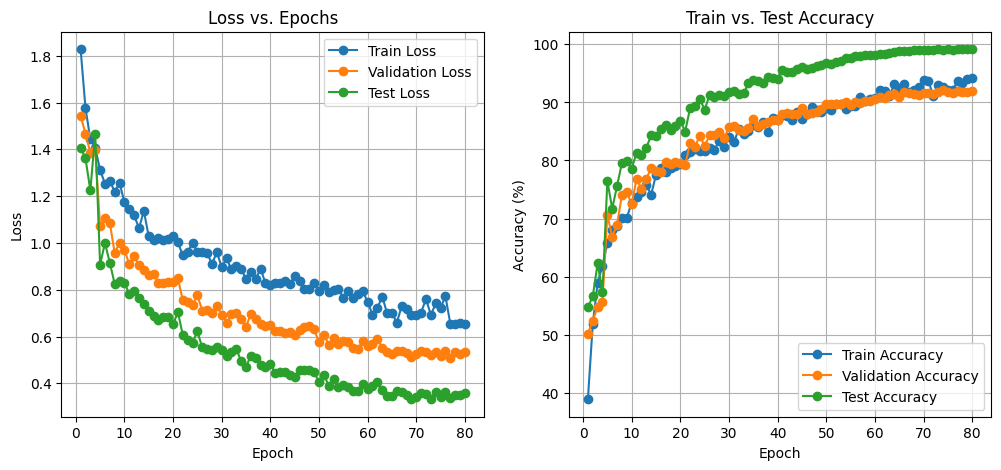

In [14]:
import matplotlib.pyplot as plt

# ✅ Plot Loss vs. Epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid()

# ✅ Plot Accuracy vs. Epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), test_accuracies, label="Test Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs. Test Accuracy")
plt.legend()
plt.grid()

plt.show()

## Evaluate the model with Test Dataset

In [15]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [16]:
dict_ = unpickle('cifar_test_nolabel.pkl')

In [17]:
# Define transform for preprocessing
transform = transforms.Compose([
      transforms.ToTensor(),  # Converts (H, W, C) NumPy to PyTorch tensor (C, H, W)
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),# Normalize
  ])

images = dict_[b'data']  # NumPy array of shape [N, H, W, C]
labels = dict_[b'ids']   # Array of integer labels

## Evaluate the model

In [18]:
model.to(device)
model.eval()

ResNetLarge(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [19]:
predictions = []
with torch.no_grad():  # No gradient calculation during evaluation
  for i in range(len(images)):
    img_np = images[i]  # Get the ith image (H, W, C)
    label = labels[i]   # Get the ith label

    # Convert NumPy image to PIL and apply transform
    img_pil = Image.fromarray(img_np.astype(np.uint8))
    img_tensor = transform(img_pil).unsqueeze(0).to(device)  # Add batch dimension

    # Forward pass through model
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)  # Get predicted class

    # Update accuracy count
    total += 1
    correct += (predicted.item() == label)
    predictions.extend(predicted.cpu().numpy())
accuracy = 100. * correct / total
print(f"Model Accuracy: {accuracy:.2f}% on provided dataset")

Model Accuracy: 77.01% on provided dataset


## Collect the final result

In [20]:
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'ID': range(len(predictions)),  # Ground truth labels
    'Labels': predictions  # Model's predictions
})

# Save to CSV
csv_filename = "predictions.csv"
df.to_csv(csv_filename, index=False)

print(f"Predictions saved to {csv_filename}")

Predictions saved to predictions.csv
